# Part 2: Bounding Box Regressor v2
Train a better CNN to recognize the coordinates for each symbol in a given image

In [1]:
import os
import time
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from PIL import Image, ImageDraw, ImageFont
from random import randrange
from IPython.display import display

In [2]:
# Configuration
WIDTH       =   200
HEIGHT      =   100
MINX        =    20
MINY        =    20
MAXX        =    WIDTH-60
MAXY        =    HEIGHT-60
MINSIZE     =    24
MAXSIZE     =    48
NUMCHARS    =     4 # 4 character CAPTCHA
SYMBOL_SIZE =    50
SYMBOL_SET  =    "0123456789"
NUM_SYMBOLS =    len(SYMBOL_SET)
FONTS_DIR   =    "../fonts"

# Training hyperparameters
BATCH_SIZE = 32
EPOCHS = 200
STEPS_PER_EPOCH = 500
VALIDATION_STEPS = 50
CHECKPOINT_PATH = "../models/box_checkpoint.keras"

In [3]:
def generate_captcha(return_image=False):
    fonts = [i for i in os.listdir(FONTS_DIR) if i.endswith('.ttf')]
    while True:
        x_pos = 0
        boxes = []
        img = Image.new('RGB', (WIDTH, HEIGHT), color = (255,255,255))
        canvas = ImageDraw.Draw(img)
        for i in range(NUMCHARS):
            font = ImageFont.truetype(f'{FONTS_DIR}/{fonts[randrange(len(fonts))]}', randrange(MINSIZE,MAXSIZE))
            character = SYMBOL_SET[randrange(NUM_SYMBOLS)]
            x_pos += randrange(10, MINX)
            y_pos = randrange(MINY, MAXY)
            position = (x_pos, y_pos)
            coords = canvas.textbbox(position, character, font)
            canvas.text(position, character, font=font, fill=(0,0,0), anchor="la")
            # Normalize the coordinates
            boxes.append([coords[0]/WIDTH, coords[1]/HEIGHT, coords[2]/WIDTH, coords[3]/HEIGHT])
            x_pos = coords[2]
        x = np.asarray(img).astype(np.float32) / 255.0
        y = np.array(boxes).flatten().astype(np.float32)
        
        if return_image:
            yield x, y, img
        else:
            yield x, y

In [4]:
# Draw the boxes
def draw_boxes(image, truth, pred=None):
    w, h = image.size
    canvas = ImageDraw.Draw(image)
    # reshape to (N,4)
    truth_boxes = np.array(truth).reshape(-1, 4)
    pred_boxes  = np.array(pred).reshape(-1, 4) if pred is not None else None
    
    for i, (xmin, ymin, xmax, ymax) in enumerate(truth_boxes):
        # scale back to pixel coordinates
        x1, y1 = int(xmin * w), int(ymin * h)
        x2, y2 = int(xmax * w), int(ymax * h)
        print("Truth", i+1, ":", x1, y1, x2, y2)
        canvas.rectangle([x1, y1, x2, y2], outline="green", width=1)

        if pred_boxes is not None:
            pxmin, pymin, pxmax, pymax = pred_boxes[i]
            px1, py1 = int(pxmin * w), int(pymin * h)
            px2, py2 = int(pxmax * w), int(pymax * h)
            print("Predicted", i+1, ":", px1, py1, px2, py2)
            canvas.rectangle([px1, py1, px2, py2], outline="red", width=1)
    display(image)

Truth 1 : 14 42 34 68
Truth 2 : 52 33 80 69
Truth 3 : 92 34 104 51
Truth 4 : 122 36 133 58


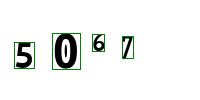

In [5]:
x, y, image = next(generate_captcha(return_image=True))
draw_boxes(image, y)

In [6]:
box_dataset = tf.data.Dataset.from_generator(generate_captcha,
            output_signature=(tf.TensorSpec(shape=(HEIGHT, WIDTH, 3), dtype=tf.float32),
                             tf.TensorSpec(shape=(4*NUMCHARS,), dtype=tf.float32)
                             ))
box_dataset = box_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [7]:
callbacks = [
    callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
    callbacks.ReduceLROnPlateau(monitor='val_loss', patience=10, factor=0.5, min_lr=1e-6),
    callbacks.ModelCheckpoint(CHECKPOINT_PATH, save_best_only=True, monitor="val_loss")
]

box_model = models.Sequential([
    layers.Input(shape=(HEIGHT, WIDTH, 3)),

    layers.Conv2D(32, 3, padding='same'), layers.BatchNormalization(), layers.ReLU(),
    layers.MaxPooling2D(2),

    layers.Conv2D(64, 3, padding='same'), layers.BatchNormalization(), layers.ReLU(),
    layers.MaxPooling2D(2),

    layers.Conv2D(128, 3, padding='same'), layers.BatchNormalization(), layers.ReLU(),
    layers.MaxPooling2D(2),

    layers.Conv2D(256, 3, padding='same'), layers.BatchNormalization(), layers.ReLU(),
    layers.MaxPooling2D(2),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(4 * NUMCHARS, activation='sigmoid')
])


box_model.compile(loss='mse', optimizer=optimizers.Adam(learning_rate=1e-4), metrics=['mae'], run_eagerly=False)

In [8]:
# Load checkpoint if any
if os.path.exists(CHECKPOINT_PATH):
    print("Loading weights from checkpoint...")
    box_model.load_weights(CHECKPOINT_PATH)
else:
    print("Starting fresh training...")

start = time.time()
box_history = box_model.fit(
    box_dataset,
    validation_data=box_dataset,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps=VALIDATION_STEPS,
    callbacks=callbacks
)
end = time.time()

Loading weights from checkpoint...
Epoch 1/200


C:\Users\priya\anaconda3\envs\sec595\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 46 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


500/500 ━━━━━━━━━━━━━━━━━━━━ 316s 623ms/step - loss: 9.3161e-04 - mae: 0.0231 - val_loss: 0.0012 - val_mae: 0.0272 - learning_rate: 1.0000e-04
Epoch 2/200
500/500 ━━━━━━━━━━━━━━━━━━━━ 309s 618ms/step - loss: 9.1372e-04 - mae: 0.0229 - val_loss: 5.9658e-04 - val_mae: 0.0190 - learning_rate: 1.0000e-04
Epoch 3/200
500/500 ━━━━━━━━━━━━━━━━━━━━ 309s 618ms/step - loss: 9.0197e-04 - mae: 0.0228 - val_loss: 7.2344e-04 - val_mae: 0.0209 - learning_rate: 1.0000e-04
Epoch 4/200
500/500 ━━━━━━━━━━━━━━━━━━━━ 316s 631ms/step - loss: 9.0058e-04 - mae: 0.0227 - val_loss: 7.3536e-04 - val_mae: 0.0210 - learning_rate: 1.0000e-04
Epoch 5/200
500/500 ━━━━━━━━━━━━━━━━━━━━ 313s 625ms/step - loss: 8.6484e-04 - mae: 0.0223 - val_loss: 7.8314e-04 - val_mae: 0.0216 - learning_rate: 1.0000e-04
Epoch 6/200
500/500 ━━━━━━━━━━━━━━━━━━━━ 316s 631ms/step - loss: 8.6935e-04 - mae: 0.0223 - val_loss: 6.5491e-04 - val_mae: 0.0198 - learning_rate: 1.0000e-04
Epoch 7/200
500/500 ━━━━━━━━━━━━━━━━━━━━ 315s 629ms/step - los

In [9]:
os.makedirs("../models", exist_ok=True)
box_model.save("../models/BBox_Regressor_v2.keras")
box_model.summary()
print(f"Total training time: {end - start:.1f}s")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 100, 200, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 100, 200, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu (ReLU)                         │ (None, 100, 200, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 50, 100, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 50, 100, 64)         │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 50, 100, 64)         │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_1 (ReLU)                       │ (None, 50, 100, 64)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 25, 50, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 25, 50, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 25, 50, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_2 (ReLU)                       │ (None, 25, 50, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 12, 25, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 12, 25, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 12, 25, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_3 (ReLU)                       │ (None, 12, 25, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 6, 12, 256)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 18432)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       4,718,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 15,430,514 (58.86 MB)

 Trainable params: 5,143,184 (19.62 MB)

 Non-trainable params: 960 (3.75 KB)

 Optimizer params: 10,286,370 (39.24 MB)

Total training time: 25082.1s


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
Truth 1 : 17 33 34 54
Predicted 1 : 15 33 32 56
Truth 2 : 47 27 65 52
Predicted 2 : 47 30 64 51
Truth 3 : 76 44 100 77
Predicted 3 : 78 43 100 73
Truth 4 : 115 36 141 69
Predicted 4 : 115 38 138 66


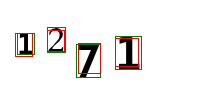

In [10]:
x, y, image = next(generate_captcha(return_image=True))
y_pred = box_model.predict(x.reshape(-1, HEIGHT, WIDTH, 3))[0]
draw_boxes(image, y, y_pred)

In [12]:
# Evaluate the Bounding Box Regressor
def unnormalize_boxes(boxes, img_h, img_w):
    boxes = boxes.copy()
    boxes[0::4] *= img_w  # x_min
    boxes[2::4] *= img_w  # x_max
    boxes[1::4] *= img_h  # y_min
    boxes[3::4] *= img_h  # y_max
    return boxes

error_margin = 5
test_size = 1000
count = 0

for i in range(test_size):
    x, y_true, image = next(generate_captcha(return_image=True))
    y_pred = box_model.predict(x.reshape(-1, HEIGHT, WIDTH, 3), verbose=False)[0]
    y_true_px = unnormalize_boxes(y_true, HEIGHT, WIDTH)
    y_pred_px = unnormalize_boxes(y_pred, HEIGHT, WIDTH)
    count += np.sum(np.abs(y_true_px - y_pred_px) > error_margin)

print("Accuracy of", (test_size-count/16)*100/test_size, "% with error margin of", error_margin, "pixels")

Accuracy of 89.18125 % with error margin of 5 pixels
